In [ ]:
#🔹 1. Import ไลบรารีที่จำเป็น
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats

In [ ]:
# 🔹 2. อ่านไฟล์ CSV และแสดงข้อมูลเบื้องต้นของอากาศ (Air Quality)
file_path_air = "../RawData/sukhothai-thammathirat.csv"
st_air = pd.read_csv(file_path_air)

# แสดงตัวอย่างข้อมูล
print("🔍 ตัวอย่างข้อมูลจากไฟล์ Air Quality CSV:")
print(st_air.head())

# ตรวจสอบประเภทข้อมูล
print("\nℹ️ ข้อมูลเบื้องต้น:")
print(st_air.info())

# ตรวจสอบค่าที่หายไป
print("\n⚠️ จำนวนค่าที่หายไปในแต่ละคอลัมน์:")
print(st_air.isnull().sum())

🔍 ตัวอย่างข้อมูลจากไฟล์ Air Quality CSV:
       date  pm25  pm10  o3  no2  so2  co
0  2025/3/1    68    26        5         
1  2025/3/2    62    27        4         
2  2025/3/3    63    23        5         
3  2025/3/4    54    27        6         
4  2025/3/5    54    19        5         

ℹ️ ข้อมูลเบื้องต้น:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3133 entries, 0 to 3132
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3133 non-null   object
 1    pm25   3133 non-null   object
 2    pm10   3133 non-null   object
 3    o3     3133 non-null   object
 4    no2    3133 non-null   object
 5    so2    3133 non-null   object
 6    co     3133 non-null   object
dtypes: object(7)
memory usage: 171.5+ KB
None

⚠️ จำนวนค่าที่หายไปในแต่ละคอลัมน์:
date     0
 pm25    0
 pm10    0
 o3      0
 no2     0
 so2     0
 co      0
dtype: int64


In [ ]:
# 🔹 3. แปลงคอลัมน์ date เป็น datetime
# แปลงคอลัมน์ 'date' เป็น datetime
st_air["date"] = pd.to_datetime(st_air["date"], errors="coerce")

# ลบช่องว่างออกจากชื่อคอลัมน์
st_air.columns = st_air.columns.str.strip()

# แปลงคอลัมน์ค่ามลพิษจาก object เป็น float
cols = ["pm25", "pm10", "o3", "no2", "so2", "co", "psi"]
cols_available = [col for col in cols if col in st_air.columns]

st_air[cols_available] = st_air[cols_available].apply(pd.to_numeric, errors="coerce")

# แสดงประเภทข้อมูลหลังแปลง
print("\n✅ ประเภทข้อมูลหลังแปลง:")
print(st_air.dtypes)


✅ ประเภทข้อมูลหลังแปลง:
date    datetime64[ns]
pm25           float64
pm10           float64
o3             float64
no2            float64
so2            float64
co             float64
dtype: object


In [ ]:
# 🔹 4. ตรวจสอบช่วงเวลาของข้อมูล
print("\n📅 ช่วงเวลาของข้อมูลใน Air Quality:")
print(f"เริ่มต้น: {st_air['date'].min()} → สิ้นสุด: {st_air['date'].max()}")


📅 ช่วงเวลาของข้อมูลใน Air Quality:
เริ่มต้น: 2013-12-31 00:00:00 → สิ้นสุด: 2025-03-30 00:00:00


In [ ]:
# 🔸 1. ตรวจสอบค่าซ้ำ (Duplicates)
# จำนวนแถวที่ซ้ำกัน
duplicate_rows = st_air.duplicated().sum()
print(f"\n🔁 จำนวนข้อมูลซ้ำทั้งหมด: {duplicate_rows}")


🔁 จำนวนข้อมูลซ้ำทั้งหมด: 0


In [ ]:
# 🔸 2. ตรวจสอบค่าหายไป (Missing Data) – คุณมีแล้ว แต่สามารถเพิ่มการ "วิเคราะห์เชิงลึก" 
missing_percent = (st_air.isnull().mean() * 100).round(2)
print("\n📉 เปอร์เซ็นต์ค่าที่หายไปในแต่ละคอลัมน์:")
print(missing_percent[missing_percent > 0])


📉 เปอร์เซ็นต์ค่าที่หายไปในแต่ละคอลัมน์:
pm25    29.43
pm10    22.28
o3      44.81
no2     24.61
so2     60.33
co      72.17
dtype: float64


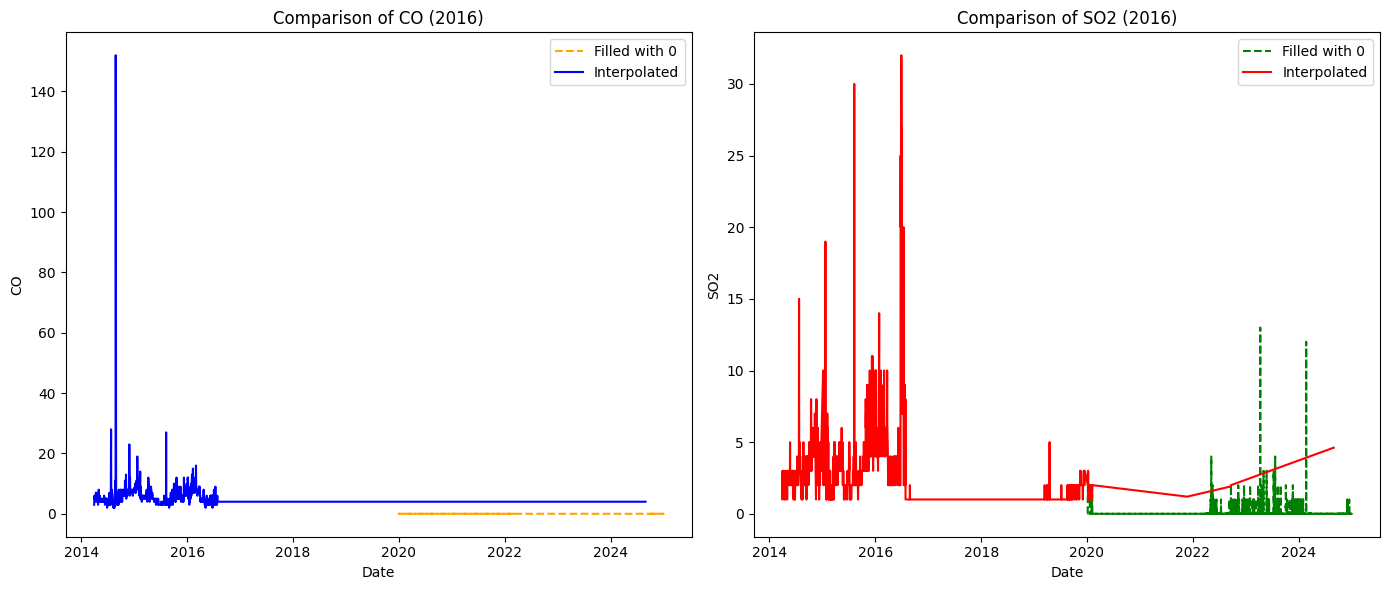

In [ ]:
# 🔹 เปรียบเทียบ co กับ so2 ที่เติมด้วย 0 vs interpolate
# ✅ เตรียมข้อมูล df (ใช้ st_air ที่จัดการแล้ว)
df = st_air.reset_index().copy()
df.columns = df.columns.str.strip()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df[["co", "so2"]] = df[["co", "so2"]].apply(pd.to_numeric, errors="coerce")

# 🔹 กำหนดช่วงปี 2020–2024
start_date = '2020-01-01'
end_date = '2024-12-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date)

# ✅ วิธีที่ 1: เติม 0
df_zero = df.copy()
df_zero[["co", "so2"]] = df_zero[["co", "so2"]].fillna(0)
df_zero = df_zero[mask]

# ✅ วิธีที่ 2: interpolate
df_interpolate = df.copy().sort_values("date")
df_interpolate.set_index("date", inplace=True)
df_interpolate[["co", "so2"]] = df_interpolate[["co", "so2"]].interpolate(method="time")
df_interpolate.reset_index(inplace=True)
df_interpolate = df_interpolate[mask]

# 🔹 วาดกราฟเปรียบเทียบ
plt.figure(figsize=(14, 6))

# 📈 CO เปรียบเทียบ
plt.subplot(1, 2, 1)
plt.plot(df_zero['date'], df_zero['co'], label='Filled with 0', linestyle='--', color='orange')
plt.plot(df_interpolate['date'], df_interpolate['co'], label='Interpolated', color='blue')
plt.title("Comparison of CO (2016)")
plt.xlabel("Date")
plt.ylabel("CO")
plt.legend()

# 📈 SO2 เปรียบเทียบ
plt.subplot(1, 2, 2)
plt.plot(df_zero['date'], df_zero['so2'], label='Filled with 0', linestyle='--', color='green')
plt.plot(df_interpolate['date'], df_interpolate['so2'], label='Interpolated', color='red')
plt.title("Comparison of SO2 (2016)")
plt.xlabel("Date")
plt.ylabel("SO2")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 🛠 จัดการค่า NaN: เติมค่า NaN ด้วย Interpolation
# 🔹 เติมค่าหายสำหรับ pm25, pm10, o3, no2 ด้วย interpolation
st_air = st_air.set_index("date")
pollutant_cols = ["pm25", "pm10", "o3", "no2"]
st_air[pollutant_cols] = st_air[pollutant_cols].interpolate(method="time")
st_air[pollutant_cols] = st_air[pollutant_cols].fillna(st_air[pollutant_cols].mean())

# 🔹 เติมค่าหายสำหรับ co, so2 ด้วย Interpolation
st_air[["co", "so2"]] = st_air[["co", "so2"]].interpolate(method="time")

# หากยังมีค่า NaN หลังจาก interpolation ให้เติมด้วยค่าเฉลี่ย
st_air[["co", "so2"]] = st_air[["co", "so2"]].fillna(st_air[["co", "so2"]].mean())

In [ ]:
# 🔸 2. ตรวจสอบค่าหายไป (Missing Data) – คุณมีแล้ว แต่สามารถเพิ่มการ "วิเคราะห์เชิงลึก" 
missing_percent = (st_air.isnull().mean() * 100).round(2)
print("\n📉 เปอร์เซ็นต์ค่าที่หายไปในแต่ละคอลัมน์:")
print(missing_percent[missing_percent > 0])


📉 เปอร์เซ็นต์ค่าที่หายไปในแต่ละคอลัมน์:
Series([], dtype: float64)


<ipython-input-86-cbbe299b031d>:7: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-86-cbbe299b031d>:7: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-86-cbbe299b031d>:7: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-86-cbbe299b031d>:7: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-86-cbbe299b031d>:7: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-86-cbbe299b031d>:7: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-86-cbbe299b031d>:7: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-inpu

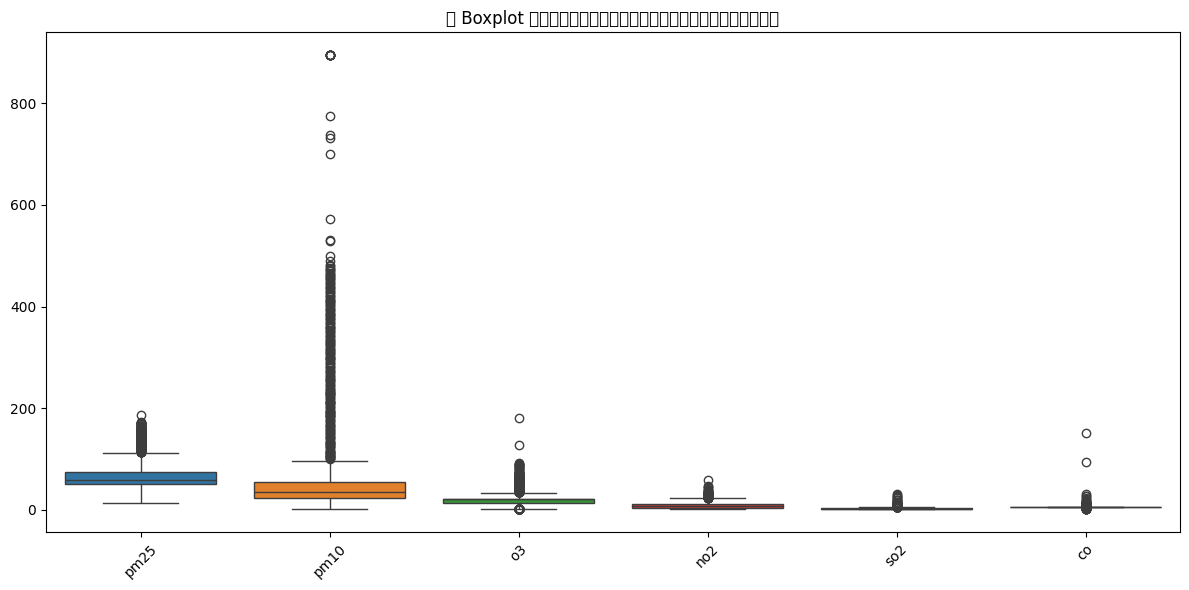

📍 pm25 มีทั้งหมด 3133 ค่า, พบ Outliers 280 ค่า
📍 pm10 มีทั้งหมด 3133 ค่า, พบ Outliers 199 ค่า
📍 o3 มีทั้งหมด 3133 ค่า, พบ Outliers 411 ค่า
📍 no2 มีทั้งหมด 3133 ค่า, พบ Outliers 66 ค่า
📍 so2 มีทั้งหมด 3133 ค่า, พบ Outliers 323 ค่า
📍 co มีทั้งหมด 3133 ค่า, พบ Outliers 909 ค่า

📊 จำนวน Outliers รวมทั้งหมด: 2188 ค่า


In [ ]:
# 🔸 3. ตรวจสอบค่าผิดปกติ (Outliers)
# Boxplot ของค่ามลพิษ
plt.figure(figsize=(12, 6))
sns.boxplot(data=st_air[cols_available])
plt.title("📦 Boxplot แสดงค่าผิดปกติของสารมลพิษ")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# คำนวณจำนวน Outliers รวมทั้งหมด พร้อมแสดงข้อมูลทั้งหมดในแต่ละคอลัมน์
total_outliers = 0

# ใช้ IQR ตรวจสอบว่ามี outliers กี่ตัวในแต่ละคอลัมน์
for col in cols_available:
    Q1 = st_air[col].quantile(0.25)
    Q3 = st_air[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((st_air[col] < (Q1 - 1.5 * IQR)) | (st_air[col] > (Q3 + 1.5 * IQR))).sum()
    
    # แสดงจำนวนข้อมูลทั้งหมดและจำนวน outliers ในแต่ละคอลัมน์
    total_rows = st_air[col].shape[0]
    print(f"📍 {col} มีทั้งหมด {total_rows} ค่า, พบ Outliers {outliers} ค่า")

    total_outliers += outliers

# แสดงจำนวน Outliers รวมทั้งหมด
print(f"\n📊 จำนวน Outliers รวมทั้งหมด: {total_outliers} ค่า")

In [ ]:
# 🛠 แก้ไข Outliers ด้วยค่าเฉลี่ย, ค่ามัธยฐาน และ Capping
# กำหนดคอลัมน์ต่างๆ ที่ต้องการแก้ไข
mean_cols = ['pm25']  # ใช้ค่าเฉลี่ยสำหรับ pm25
median_cols = ['so2', 'pm10', 'no2', 'co']  # ใช้ค่ามัธยฐานสำหรับ so2, pm10, no2, co
capping_cols = ['o3']  # ใช้ Capping สำหรับ o3

# 🔹 1. แก้ไข pm25 ด้วยค่าเฉลี่ย
for col in mean_cols:
    Q1 = st_air[col].quantile(0.25)
    Q3 = st_air[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # แทนที่ outliers ด้วยค่าเฉลี่ย
    mean_value = st_air[col].mean()
    st_air[col] = st_air[col].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)
    print(f"📍 {col} แก้ไข outliers ด้วยค่าเฉลี่ย")

# 🔹 2. แก้ไข so2, pm10, no2, co ด้วยค่ามัธยฐาน
for col in median_cols:
    Q1 = st_air[col].quantile(0.25)
    Q3 = st_air[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # แทนที่ outliers ด้วยค่ามัธยฐาน
    median_value = st_air[col].median()
    st_air[col] = st_air[col].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)
    print(f"📍 {col} แก้ไข outliers ด้วยค่ามัธยฐาน")

# 🔹 3. แก้ไข o3 ด้วย Capping
for col in capping_cols:
    Q1 = st_air[col].quantile(0.25)
    Q3 = st_air[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping: จำกัดค่าต่ำสุดไม่ต่ำกว่าขอบล่าง และค่าที่สูงสุดไม่เกินขอบบน
    st_air[col] = st_air[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    print(f"📍 {col} ใช้ Capping เพื่อจำกัดค่าผิดปกติ")

# สรุปผลการแก้ไข
print("\n🔧 แก้ไข outliers แล้ว")

📍 pm25 แก้ไข outliers ด้วยค่าเฉลี่ย
📍 so2 แก้ไข outliers ด้วยค่ามัธยฐาน
📍 pm10 แก้ไข outliers ด้วยค่ามัธยฐาน
📍 no2 แก้ไข outliers ด้วยค่ามัธยฐาน
📍 co แก้ไข outliers ด้วยค่ามัธยฐาน
📍 o3 ใช้ Capping เพื่อจำกัดค่าผิดปกติ

🔧 แก้ไข outliers แล้ว


In [ ]:
# คำนวณจำนวน Outliers รวมทั้งหมด พร้อมแสดงข้อมูลทั้งหมดในแต่ละคอลัมน์
total_outliers = 0

# ใช้ IQR ตรวจสอบว่ามี outliers กี่ตัวในแต่ละคอลัมน์
for col in cols_available:
    Q1 = st_air[col].quantile(0.25)
    Q3 = st_air[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((st_air[col] < (Q1 - 1.5 * IQR)) | (st_air[col] > (Q3 + 1.5 * IQR))).sum()
    
    # แสดงจำนวนข้อมูลทั้งหมดและจำนวน outliers ในแต่ละคอลัมน์
    total_rows = st_air[col].shape[0]
    print(f"📍 {col} มีทั้งหมด {total_rows} ค่า, พบ Outliers {outliers} ค่า")

    total_outliers += outliers

# แสดงจำนวน Outliers รวมทั้งหมด
print(f"\n📊 จำนวน Outliers รวมทั้งหมด: {total_outliers} ค่า")

📍 pm25 มีทั้งหมด 3133 ค่า, พบ Outliers 358 ค่า
📍 pm10 มีทั้งหมด 3133 ค่า, พบ Outliers 25 ค่า
📍 o3 มีทั้งหมด 3133 ค่า, พบ Outliers 0 ค่า
📍 no2 มีทั้งหมด 3133 ค่า, พบ Outliers 36 ค่า
📍 so2 มีทั้งหมด 3133 ค่า, พบ Outliers 285 ค่า
📍 co มีทั้งหมด 3133 ค่า, พบ Outliers 0 ค่า

📊 จำนวน Outliers รวมทั้งหมด: 704 ค่า


C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3617 (\N{

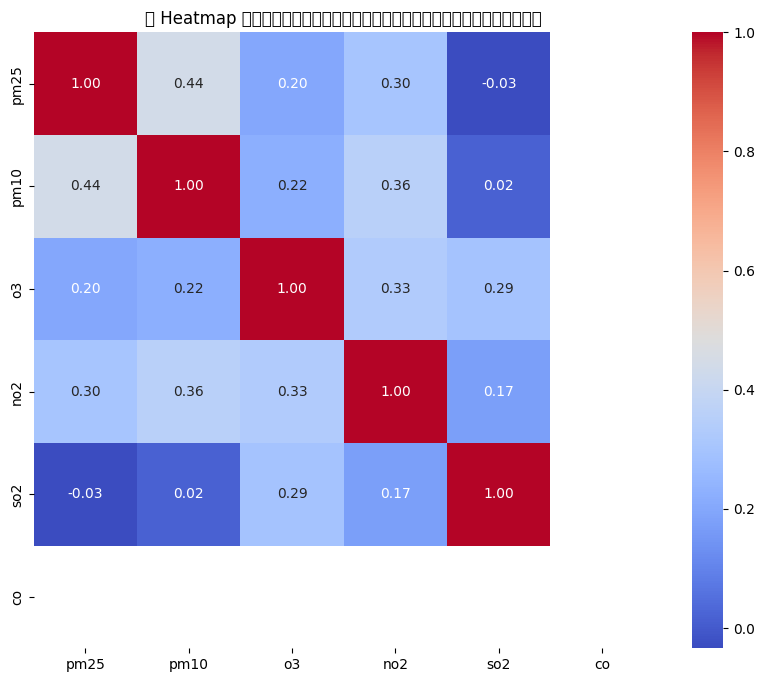

In [ ]:
#🔸 4. ตรวจสอบความสัมพันธ์ของตัวแปร (Correlation)
plt.figure(figsize=(10, 8))
sns.heatmap(st_air[cols_available].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("📊 Heatmap ความสัมพันธ์ระหว่างตัวแปรมลพิษ")
plt.show()

In [ ]:
# เพิ่มฟังก์ชันคำนวณ AQI
def calc_aqi(value, bins, aqi_range):
    """คำนวณ AQI จากค่ามลพิษโดยใช้ binning และช่วง AQI"""
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]:
            return ((aqi_range[i + 1] - aqi_range[i]) / (bins[i + 1] - bins[i])) * (value - bins[i]) + aqi_range[i]
    return aqi_range[-1]  # สำหรับค่าที่มากที่สุด

# เกณฑ์ AQI สำหรับแต่ละประเภทมลพิษ
pollutant_bins = {
    'pm25': [0, 25, 37, 50, 90, float('inf')],
    'pm10': [0, 50, 80, 120, 180, float('inf')],
    'co': [0, 4.4, 6.4, 9.0, 30, float('inf')],
    'o3': [0, 35, 50, 70, 120, float('inf')],
    'no2': [0, 60, 106, 170, 340, float('inf')],
    'so2': [0, 100, 200, 300, 400, float('inf')]
}

# ช่วง AQI สำหรับแต่ละประเภทมลพิษ
aqi_ranges = {
    'pm25': [0, 25, 50, 100, 200, 500],
    'pm10': [0, 25, 50, 100, 200, 500],
    'co': [0, 25, 50, 100, 200, 500],
    'o3': [0, 25, 50, 100, 200, 500],
    'no2': [0, 25, 50, 100, 200, 500],
    'so2': [0, 25, 50, 100, 200, 500]
}

# คำนวณ AQI สำหรับทุกแถว
def calculate_aqi(row):
    aqi_values = [
        calc_aqi(row['pm25'], pollutant_bins['pm25'], aqi_ranges['pm25']),
        calc_aqi(row['pm10'], pollutant_bins['pm10'], aqi_ranges['pm10']),
        calc_aqi(row['co'], pollutant_bins['co'], aqi_ranges['co']),
        calc_aqi(row['o3'], pollutant_bins['o3'], aqi_ranges['o3']),
        calc_aqi(row['no2'], pollutant_bins['no2'], aqi_ranges['no2']),
        calc_aqi(row['so2'], pollutant_bins['so2'], aqi_ranges['so2'])
    ]
    return max(aqi_values)

In [ ]:
# ตรวจสอบคอลัมน์ "level_0"
if "level_0" in st_air.columns:
    # ลบคอลัมน์ "level_0"
    st_air.drop("level_0", axis=1, inplace=True)

# รีเซ็ต index
st_air.reset_index(inplace=True)

# คำนวณ AQI และเพิ่มใน DataFrame
st_air['AQI'] = st_air.apply(calculate_aqi, axis=1)

# แสดงผล AQI
print(st_air[['date', 'AQI']].head())

        date    AQI
0 2025-03-01  145.0
1 2025-03-02  130.0
2 2025-03-03  132.5
3 2025-03-04  110.0
4 2025-03-05  110.0


In [ ]:
# 🔹 1. อ่านไฟล์ CSV แสดงข้อมูลเบื้องต้นของสภาพอากาศ 
file_path_air = "../RawData/sukhothai-thammathirat  2020-2024.csv"
st_weather = pd.read_csv(file_path_air)

# แสดงตัวอย่างข้อมูล
print("🔍 ตัวอย่างข้อมูลจากไฟล์ Air Quality CSV:")
print(st_weather.head())

# ตรวจสอบประเภทข้อมูล
print("\nℹ️ ข้อมูลเบื้องต้น:")
print(st_weather.info())

🔍 ตัวอย่างข้อมูลจากไฟล์ Air Quality CSV:
                  date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  \
0  2020-01-01 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  2020-01-02 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2  2020-01-03 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3  2020-01-04 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  2020-01-05 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   tsun  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  

ℹ️ ข้อมูลเบื้องต้น:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1827 non-null   object 
 1   tavg    1456 non-null   float64
 2   tmin    1456 non-null   float64
 3   tmax    1456 non-null   float64
 4   prcp    1446 non-null   float64
 5   snow    0 non-null      fl

In [ ]:
# 🔹 2. แปลงคอลัมน์ date เป็น datetime
# แปลงคอลัมน์ 'date' เป็น datetime
st_weather["date"] = pd.to_datetime(st_weather["date"], errors="coerce")

# ลบช่องว่างออกจากชื่อคอลัมน์
st_weather.columns = st_weather.columns.str.strip()

# แสดงประเภทข้อมูลหลังแปลง
print("\n✅ ประเภทข้อมูลหลังแปลง:")
print(st_weather.dtypes)


✅ ประเภทข้อมูลหลังแปลง:
date    datetime64[ns]
tavg           float64
tmin           float64
tmax           float64
prcp           float64
snow           float64
wdir           float64
wspd           float64
wpgt           float64
pres           float64
tsun           float64
dtype: object


In [ ]:
# 🔹 3. ตรวจสอบช่วงเวลาของข้อมูล
print("\n📅 ช่วงเวลาของข้อมูลใน Air Quality:")
print(f"เริ่มต้น: {st_weather['date'].min()} → สิ้นสุด: {st_weather['date'].max()}")


📅 ช่วงเวลาของข้อมูลใน Air Quality:
เริ่มต้น: 2020-01-01 00:00:00 → สิ้นสุด: 2024-12-31 00:00:00


In [ ]:
# 🔸 1. ตรวจสอบค่าซ้ำ (Duplicates)
duplicates = st_weather.duplicated()
print(f"\n🔁 จำนวนแถวที่ซ้ำกัน: {duplicates.sum()}")
if duplicates.any():
    print("→ มีแถวที่ซ้ำกัน ตัวอย่าง:")
    print(st_weather[duplicates].head())


🔁 จำนวนแถวที่ซ้ำกัน: 0


In [ ]:
# 🔸 2. ตรวจสอบค่าหายไป (Missing Data)
missing_counts = st_weather.isnull().sum()
missing_percent = (missing_counts / len(st_weather)) * 100
print("\n🚫 ค่าที่หายไปในแต่ละคอลัมน์:")
print(pd.DataFrame({"จำนวนที่หาย": missing_counts, "เปอร์เซ็นต์ (%)": missing_percent.round(2)}))


🚫 ค่าที่หายไปในแต่ละคอลัมน์:
      จำนวนที่หาย  เปอร์เซ็นต์ (%)
date            0             0.00
tavg          371            20.31
tmin          371            20.31
tmax          371            20.31
prcp          381            20.85
snow         1827           100.00
wdir          371            20.31
wspd          371            20.31
wpgt         1827           100.00
pres          379            20.74
tsun         1827           100.00


       count         mean         std     min       25%     50%      75%  \
tavg  1456.0    27.911607    2.576664    19.1    26.375    27.9    29.50   
tmin  1456.0    23.601442    2.869116    13.8    22.200    24.2    25.50   
tmax  1456.0    33.532898    2.813137    23.9    31.700    33.3    35.00   
prcp  1446.0     5.426279    9.828546     0.0     0.000     0.4     7.20   
wdir  1456.0   183.796016  114.027303     0.0    98.000   168.0   285.25   
wspd  1456.0     5.353915    2.609127     0.3     3.500     4.9     6.50   
pres  1448.0  1008.875276    3.610596  1000.6  1005.900  1008.5  1011.50   

         max  
tavg    36.1  
tmin    30.6  
tmax    42.8  
prcp   101.1  
wdir   359.0  
wspd    17.6  
pres  1020.2  

📌 ค่ามัธยฐาน (Median):
tavg      27.9
tmin      24.2
tmax      33.3
prcp       0.4
wdir     168.0
wspd       4.9
pres    1008.5
dtype: float64


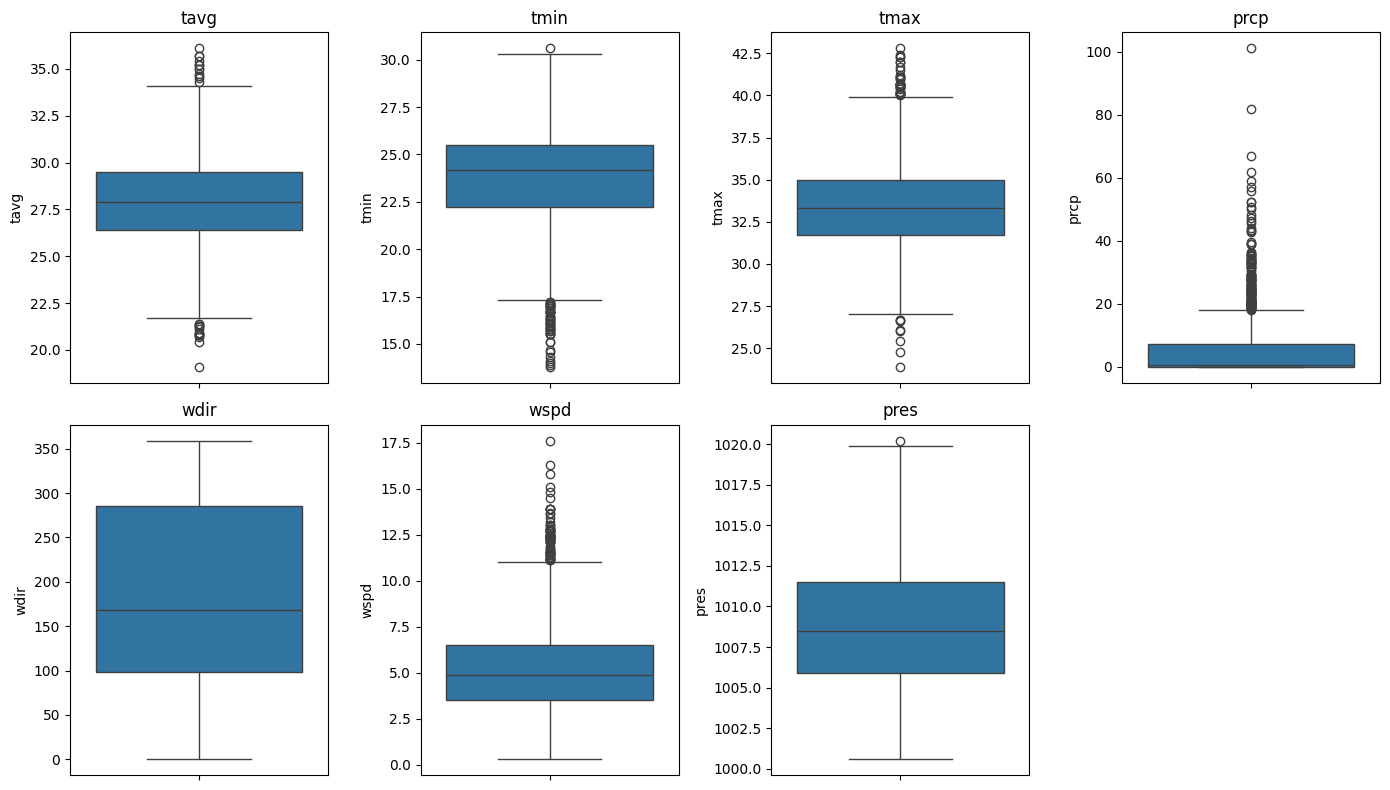

In [ ]:
# ตรวจดูว่าควรใช้ค่า mean หรือ median อันไหนเหมาะกว่าในแต่ละคอลัมน์
# สรุปค่าทางสถิติของแต่ละคอลัมน์
print(st_weather[["tavg", "tmin", "tmax", "prcp", "wdir", "wspd", "pres"]].describe().T)

# เพิ่มการคำนวณ median แสดงข้างๆ
medians = st_weather[["tavg", "tmin", "tmax", "prcp", "wdir", "wspd", "pres"]].median()
print("\n📌 ค่ามัธยฐาน (Median):")
print(medians)

# ตั้งค่าขนาดกราฟ
plt.figure(figsize=(14, 8))
cols_to_plot = ["tavg", "tmin", "tmax", "prcp", "wdir", "wspd", "pres"]

# วาดกราฟ boxplot สำหรับแต่ละคอลัมน์
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=st_weather, y=col)
    plt.title(col)

plt.tight_layout()
plt.show()

In [ ]:
# 🛠 แก้ไข Missing ด้วยค่าเฉลี่ย, ค่ามัธยฐาน และ ลบคอลัมน์ที่มีค่าหายทั้งหมด
# ใช้ mean
mean_cols = ["tavg", "tmax", "pres"]
st_weather[mean_cols] = st_weather[mean_cols].fillna(st_weather[mean_cols].mean())

# ใช้ median
median_cols = ["tmin", "prcp", "wdir", "wspd"]
st_weather[median_cols] = st_weather[median_cols].fillna(st_weather[median_cols].median())

# ลบคอลัมน์ที่มีค่าหายทั้งหมด
st_weather = st_weather.drop(columns=["snow", "wpgt", "tsun"])

In [ ]:
missing_counts = st_weather.isnull().sum()
missing_percent = (missing_counts / len(st_weather)) * 100
print("\n🚫 ค่าที่หายไปในแต่ละคอลัมน์:")
print(pd.DataFrame({"จำนวนที่หาย": missing_counts, "เปอร์เซ็นต์ (%)": missing_percent.round(2)}))


🚫 ค่าที่หายไปในแต่ละคอลัมน์:
      จำนวนที่หาย  เปอร์เซ็นต์ (%)
date            0              0.0
tavg            0              0.0
tmin            0              0.0
tmax            0              0.0
prcp            0              0.0
wdir            0              0.0
wspd            0              0.0
pres            0              0.0


<ipython-input-109-294348668ff4>:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-109-294348668ff4>:10: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-109-294348668ff4>:10: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-109-294348668ff4>:10: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-109-294348668ff4>:10: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-109-294348668ff4>:10: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-109-294348668ff4>:10: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

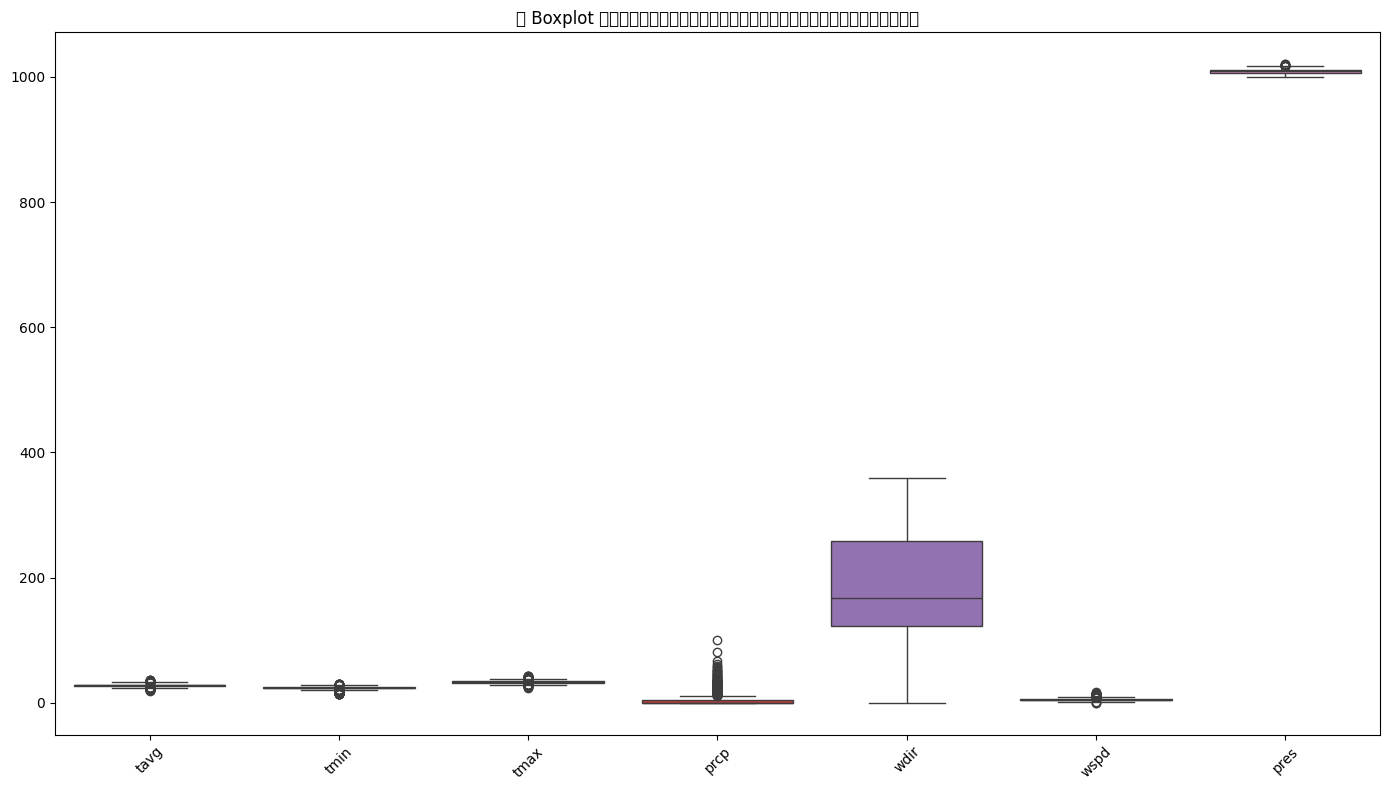


⚠️ สรุปจำนวนค่าผิดปกติ (Outliers):
📍 tavg มีทั้งหมด 1827 ค่า, พบ Outliers 124 ค่า
📍 tmin มีทั้งหมด 1827 ค่า, พบ Outliers 193 ค่า
📍 tmax มีทั้งหมด 1827 ค่า, พบ Outliers 123 ค่า
📍 prcp มีทั้งหมด 1827 ค่า, พบ Outliers 249 ค่า
📍 wdir มีทั้งหมด 1827 ค่า, พบ Outliers 0 ค่า
📍 wspd มีทั้งหมด 1827 ค่า, พบ Outliers 141 ค่า
📍 pres มีทั้งหมด 1827 ค่า, พบ Outliers 14 ค่า

📊 จำนวน Outliers รวมทั้งหมดในข้อมูลสภาพอากาศ: 844 ค่า


In [ ]:
# 🔸 3. ตรวจสอบค่าผิดปกติ (Outliers) ด้วย IQR
numeric_cols = st_weather.select_dtypes(include='number').columns
total_outliers = 0

# 🔹 Boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=st_weather[numeric_cols])
plt.title("📦 Boxplot แสดงค่าผิดปกติของข้อมูลสภาพอากาศ")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n⚠️ สรุปจำนวนค่าผิดปกติ (Outliers):")
total_outliers = 0

for col in numeric_cols:
    Q1 = st_weather[col].quantile(0.25)
    Q3 = st_weather[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((st_weather[col] < lower_bound) | (st_weather[col] > upper_bound)).sum()
    total_rows = st_weather[col].shape[0]

    print(f"📍 {col} มีทั้งหมด {total_rows} ค่า, พบ Outliers {outliers} ค่า")

    total_outliers += outliers

# แสดงจำนวน Outliers รวมทั้งหมด
print(f"\n📊 จำนวน Outliers รวมทั้งหมดในข้อมูลสภาพอากาศ: {total_outliers} ค่า")

In [ ]:
# 🛠 Outliers
# 🔹 tavg, tmin, tmax, pres → แทนค่าผิดปกติด้วย median
cols_replace_with_median = ["tavg", "tmin", "tmax", "pres"]

for col in cols_replace_with_median:
    Q1 = st_weather[col].quantile(0.25)
    Q3 = st_weather[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    median = st_weather[col].median()
    st_weather[col] = st_weather[col].apply(lambda x: median if x < lower or x > upper else x)

# 🔹 wspd → Clip ค่าเกินขอบเขต (แทนค่าที่อยู่นอก IQR boundary ด้วยค่า boundary)
Q1 = st_weather["wspd"].quantile(0.25)
Q3 = st_weather["wspd"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
st_weather["wspd"] = st_weather["wspd"].clip(lower, upper)

# 🔹 prcp → ใช้ log transform (log1p = log(1 + x) เพื่อเลี่ยง log(0))
st_weather["prcp_log"] = np.log1p(st_weather["prcp"])

In [ ]:
print("\n⚠️ สรุปจำนวนค่าผิดปกติ (Outliers):")
total_outliers = 0

for col in numeric_cols:
    Q1 = st_weather[col].quantile(0.25)
    Q3 = st_weather[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((st_weather[col] < lower_bound) | (st_weather[col] > upper_bound)).sum()
    total_rows = st_weather[col].shape[0]

    print(f"📍 {col} มีทั้งหมด {total_rows} ค่า, พบ Outliers {outliers} ค่า")

    total_outliers += outliers

# แสดงจำนวน Outliers รวมทั้งหมด
print(f"\n📊 จำนวน Outliers รวมทั้งหมดในข้อมูลสภาพอากาศ: {total_outliers} ค่า")


⚠️ สรุปจำนวนค่าผิดปกติ (Outliers):
📍 tavg มีทั้งหมด 1827 ค่า, พบ Outliers 104 ค่า
📍 tmin มีทั้งหมด 1827 ค่า, พบ Outliers 281 ค่า
📍 tmax มีทั้งหมด 1827 ค่า, พบ Outliers 165 ค่า
📍 prcp มีทั้งหมด 1827 ค่า, พบ Outliers 249 ค่า
📍 wdir มีทั้งหมด 1827 ค่า, พบ Outliers 0 ค่า
📍 wspd มีทั้งหมด 1827 ค่า, พบ Outliers 0 ค่า
📍 pres มีทั้งหมด 1827 ค่า, พบ Outliers 2 ค่า

📊 จำนวน Outliers รวมทั้งหมดในข้อมูลสภาพอากาศ: 801 ค่า


In [ ]:
# 🔹 แก้ tmin, tmax: Use clip instead of median to handle outliers
for col in ["tmin", "tmax"]:
    Q1 = st_weather[col].quantile(0.25)
    Q3 = st_weather[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    st_weather[col] = st_weather[col].clip(lower, upper)

In [ ]:
print("\n⚠️ สรุปจำนวนค่าผิดปกติ (Outliers):")
total_outliers = 0

for col in numeric_cols:
    Q1 = st_weather[col].quantile(0.25)
    Q3 = st_weather[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((st_weather[col] < lower_bound) | (st_weather[col] > upper_bound)).sum()
    total_rows = st_weather[col].shape[0]

    print(f"📍 {col} มีทั้งหมด {total_rows} ค่า, พบ Outliers {outliers} ค่า")

    total_outliers += outliers

# แสดงจำนวน Outliers รวมทั้งหมด
print(f"\n📊 จำนวน Outliers รวมทั้งหมดในข้อมูลสภาพอากาศ: {total_outliers} ค่า")


⚠️ สรุปจำนวนค่าผิดปกติ (Outliers):
📍 tavg มีทั้งหมด 1827 ค่า, พบ Outliers 104 ค่า
📍 tmin มีทั้งหมด 1827 ค่า, พบ Outliers 0 ค่า
📍 tmax มีทั้งหมด 1827 ค่า, พบ Outliers 0 ค่า
📍 prcp มีทั้งหมด 1827 ค่า, พบ Outliers 249 ค่า
📍 wdir มีทั้งหมด 1827 ค่า, พบ Outliers 0 ค่า
📍 wspd มีทั้งหมด 1827 ค่า, พบ Outliers 0 ค่า
📍 pres มีทั้งหมด 1827 ค่า, พบ Outliers 2 ค่า

📊 จำนวน Outliers รวมทั้งหมดในข้อมูลสภาพอากาศ: 355 ค่า



📈 ความสัมพันธ์ระหว่างตัวแปร:


<ipython-input-114-61d68d1b1fbf>:8: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-61d68d1b1fbf>:8: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-61d68d1b1fbf>:8: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-61d68d1b1fbf>:8: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-61d68d1b1fbf>:8: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-61d68d1b1fbf>:8: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-114-61d68d1b1fbf>:8: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout

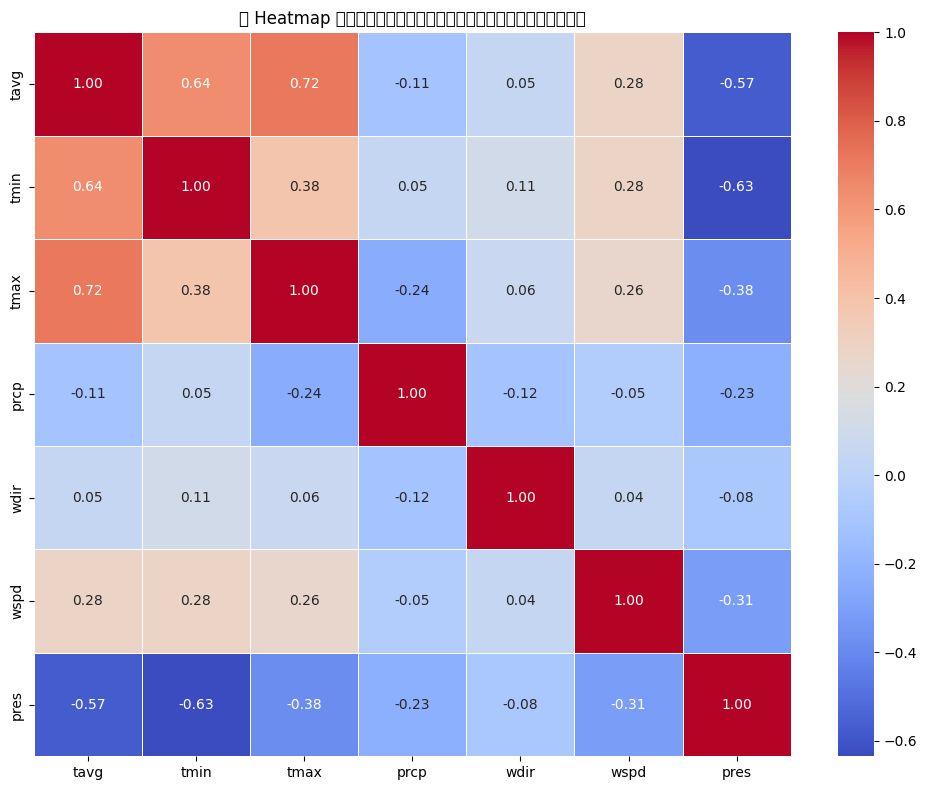

In [ ]:
# 🔸 4. ตรวจสอบความสัมพันธ์ของตัวแปร (Correlation)
print("\n📈 ความสัมพันธ์ระหว่างตัวแปร:")
correlation_matrix = st_weather[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("🔗 Heatmap ความสัมพันธ์ระหว่างตัวแปร")
plt.tight_layout()
plt.show()

In [ ]:
# Filter the data for the period 2020-2024
start_date = '2020-01-01'
end_date = '2024-12-31'

# Filter air quality data (st_air)
st_air_filtered = st_air[(st_air['date'] >= start_date) & (st_air['date'] <= end_date)]

# Filter weather data (st_weather)
st_weather_filtered = st_weather[(st_weather['date'] >= start_date) & (st_weather['date'] <= end_date)]

# Step 2: Merge the two datasets on the 'date' column
merged_data = pd.merge(st_air_filtered, st_weather_filtered, on='date', how='inner')

# Show the merged data
print("\n🔗 ข้อมูลที่รวมกันจาก Air Quality และ Weather Data:")
print(merged_data.head())


🔗 ข้อมูลที่รวมกันจาก Air Quality และ Weather Data:
   level_0  index       date  pm25  pm10         o3   no2       so2        co  \
0       89     89 2024-10-01  47.0  23.0  20.775254   9.0  3.371025  6.267117   
1       90     90 2024-10-02  53.0  19.0  20.775254   9.0  3.332155  6.267117   
2       91     91 2024-10-03  46.0  21.0  20.775254  11.0  3.293286  6.267117   
3       92     92 2024-10-04  50.0  41.0  20.775254  11.0  3.254417  6.267117   
4       93     93 2024-10-05  84.0  46.0  20.775254   8.0  3.215548  6.267117   

          AQI  tavg  tmin  tmax   prcp   wdir  wspd    pres  prcp_log  
0   88.461538  28.6  26.2  31.8   20.9   62.0   2.1  1005.7  3.086487  
1  107.500000  26.1  24.3  29.5  101.1   36.0   2.7  1008.6  4.625953  
2   84.615385  26.5  24.2  29.6   66.8   42.0   3.1  1010.3  4.216562  
3  100.000000  27.7  25.2  31.4   17.9   22.0   2.7  1010.8  2.939162  
4  185.000000  28.2  23.8  33.0   13.5  358.0   2.0  1010.7  2.674149  


In [ ]:
# ลบ index,level_0 ,prcp_log  ,tmin  ,tmax   
columns_to_drop = ['index', 'level_0', 'prcp_log', 'tmin', 'tmax']
merged_data = merged_data.drop(columns=[col for col in columns_to_drop if col in merged_data.columns])

In [ ]:
# Show the merged data
print("\n🔗 ข้อมูลที่รวมกันจาก Air Quality และ Weather Data:")
print(merged_data.head())


🔗 ข้อมูลที่รวมกันจาก Air Quality และ Weather Data:
        date  pm25  pm10         o3   no2       so2        co         AQI  \
0 2024-10-01  47.0  23.0  20.775254   9.0  3.371025  6.267117   88.461538   
1 2024-10-02  53.0  19.0  20.775254   9.0  3.332155  6.267117  107.500000   
2 2024-10-03  46.0  21.0  20.775254  11.0  3.293286  6.267117   84.615385   
3 2024-10-04  50.0  41.0  20.775254  11.0  3.254417  6.267117  100.000000   
4 2024-10-05  84.0  46.0  20.775254   8.0  3.215548  6.267117  185.000000   

   tavg   prcp   wdir  wspd    pres  
0  28.6   20.9   62.0   2.1  1005.7  
1  26.1  101.1   36.0   2.7  1008.6  
2  26.5   66.8   42.0   3.1  1010.3  
3  27.7   17.9   22.0   2.7  1010.8  
4  28.2   13.5  358.0   2.0  1010.7  


In [ ]:
# แสดงรายละเอียดของข้อมูล df_merged
# 🔹 1. แสดงชื่อคอลัมน์ทั้งหมดในชุดข้อมูล
print("📌 คอลัมน์ทั้งหมดในชุดข้อมูล:")
print(merged_data.columns)

📌 คอลัมน์ทั้งหมดในชุดข้อมูล:
Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'AQI', 'tavg', 'prcp',
       'wdir', 'wspd', 'pres'],
      dtype='object')


In [ ]:
# 🔹 2. แสดงช่วงเวลาของข้อมูล
print("\n📅 ช่วงเวลาของข้อมูล:")
print(f"เริ่มต้น: {merged_data['date'].min()} → สิ้นสุด: {merged_data['date'].max()}")


📅 ช่วงเวลาของข้อมูล:
เริ่มต้น: 2020-01-01 00:00:00 → สิ้นสุด: 2024-12-31 00:00:00


In [ ]:
# 🔹 3. แสดงความถี่ของข้อมูลในแต่ละเดือน แยกตามปี
merged_data['Year'] = merged_data['date'].dt.year  # ดึงข้อมูลปี
merged_data['Month'] = merged_data['date'].dt.month  # ดึงข้อมูลเดือน

monthly_counts_by_year = merged_data.groupby(['Year', 'Month']).size().unstack()

print("\n📊 ความถี่ของข้อมูลในแต่ละเดือน แยกตามปี:")
print(monthly_counts_by_year)


📊 ความถี่ของข้อมูลในแต่ละเดือน แยกตามปี:
Month  1   2   3   4   5   6   7   8   9   10  11  12
Year                                                 
2020   31  29  30  30  31  30  31  31  30  31  30  31
2021   31  28  31  30  31  30  31  31  30  31  30  31
2022   31  28  31  30  31  30  31  31  30  31  30  31
2023   31  28  31  30  31  30  31  31  30  31  30  31
2024   31  29  31  30  31  30  31  31  30  31  30  30


In [ ]:
# 🔹 4. แสดงข้อมูลสถิติ
print("\n📈 ข้อมูลสถิติของชุดข้อมูล:")
print(merged_data.describe())


📈 ข้อมูลสถิติของชุดข้อมูล:
                                date         pm25         pm10           o3  \
count                           1825  1825.000000  1825.000000  1825.000000   
mean   2022-07-01 22:50:33.863013632    58.958849    35.080457    17.178672   
min              2020-01-01 00:00:00    13.000000     1.000000     2.000000   
25%              2021-04-02 00:00:00    40.000000    21.000000    12.000000   
50%              2022-07-02 00:00:00    60.000000    32.000000    20.775254   
75%              2023-10-01 00:00:00    71.000000    46.000000    20.775254   
max              2024-12-31 00:00:00   112.000000    95.000000    34.000000   
std                              NaN    22.347309    17.187178     7.382986   

               no2          so2            co          AQI         tavg  \
count  1825.000000  1825.000000  1.825000e+03  1825.000000  1825.000000   
mean      6.939180     1.641444  6.267117e+00   118.026528    27.935690   
min       1.000000     1.000000  6.

In [ ]:
# 🔹 5. ตรวจสอบจำนวนข้อมูลในแต่ละปี
merged_data['Year'] = merged_data['date'].dt.year  # ดึงข้อมูลปีออกมา
yearly_counts = merged_data['Year'].value_counts().sort_index()
print("\n📆 จำนวนข้อมูลในแต่ละปี:")
print(yearly_counts)


📆 จำนวนข้อมูลในแต่ละปี:
Year
2020    365
2021    365
2022    365
2023    365
2024    365
Name: count, dtype: int64


In [ ]:
# 🔹 6. แสดงผลรวมของจำนวนข้อมูลทั้งหมดในทุกปี
total_records = yearly_counts.sum()

print("\n📊 จำนวนข้อมูลทั้งหมดในทุกปีรวมกัน:")
print(total_records)

print(merged_data.dtypes)


📊 จำนวนข้อมูลทั้งหมดในทุกปีรวมกัน:
1825
date     datetime64[ns]
pm25            float64
pm10            float64
o3              float64
no2             float64
so2             float64
co              float64
AQI             float64
tavg            float64
prcp            float64
wdir            float64
wspd            float64
pres            float64
Year              int32
Month             int32
dtype: object


In [ ]:
# 🔹 ปัดค่าทศนิยมเฉพาะคอลัมน์ตัวเลขให้เหลือ 2 ตำแหน่ง
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns
merged_data[numeric_cols] = merged_data[numeric_cols].round(2)

merged_data.reset_index(drop=True, inplace=True)
print("📊 ตัวอย่างข้อมูลหลังปัดค่าทศนิยม:")
print(merged_data.head(10))

📊 ตัวอย่างข้อมูลหลังปัดค่าทศนิยม:
        date   pm25  pm10     o3   no2   so2    co     AQI  tavg   prcp  \
0 2024-10-01   47.0  23.0  20.78   9.0  3.37  6.27   88.46  28.6   20.9   
1 2024-10-02   53.0  19.0  20.78   9.0  3.33  6.27  107.50  26.1  101.1   
2 2024-10-03   46.0  21.0  20.78  11.0  3.29  6.27   84.62  26.5   66.8   
3 2024-10-04   50.0  41.0  20.78  11.0  3.25  6.27  100.00  27.7   17.9   
4 2024-10-05   84.0  46.0  20.78   8.0  3.22  6.27  185.00  28.2   13.5   
5 2024-10-06   97.0  48.0  20.78  10.0  3.18  6.27  200.00  29.3    0.3   
6 2024-10-07  109.0  50.0  20.78  13.0  3.14  6.27  200.00  29.4    0.1   
7 2024-10-08  111.0  24.0  20.78  11.0  3.10  6.27  200.00  29.6    1.2   
8 2024-10-09   56.0  40.0  20.78  12.0  3.06  6.27  115.00  29.5    1.4   
9 2024-10-10   89.0  32.0  20.78  10.0  3.02  6.27  197.50  29.1    0.7   

    wdir  wspd    pres  Year  Month  
0   62.0   2.1  1005.7  2024     10  
1   36.0   2.7  1008.6  2024     10  
2   42.0   3.1  1010.3  20